In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers, regularizers, models, optimizers, losses, callbacks, metrics

2025-11-04 16:47:04.569747: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-04 16:47:04.589840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762271224.604961  301645 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762271224.610668  301645 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762271224.630877  301645 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
# Columns
# has_diabetes: 0/1 (TARGET)
# age: integer
# sex: male/female
# hypertension: yes/no
# Enferemedad_vascular: yes/no
# Smoker: yes/no
# bmi: decimal
# Hba1c_cuan: decimal
# Hba1c_cual: normal/not normal
# random_glucose: decimal (maybe into cuantified/cualified setup)

## Entrenamiento del modelo

In [2]:
train_df = pd.read_csv('train_data.csv', index_col=0)
test_df = pd.read_csv('test_data.csv', index_col=0)
train_df.head()

,patient_id,has_diabetes,age,gender,hypertension,heart_disease,smoker,bmi,glucose,hba1c,hba1c_cual,glucose_cual
0,82555.0,0.0,16.0,1.0,0.0,0.0,0.0,21.49,NaN,6.2,NaN,0.0
1,92299.0,0.0,15.0,1.0,0.0,0.0,0.0,33.62,158.0,NaN,0.0,0.0
2,18725.0,0.0,54.0,0.0,0.0,0.0,1.0,21.46,145.0,NaN,0.0,NaN
3,52208.0,1.0,54.0,1.0,0.0,0.0,0.0,39.12,NaN,NaN,1.0,1.0
4,2640.0,0.0,29.0,1.0,0.0,0.0,1.0,38.25,126.0,3.5,1.0,1.0


In [5]:
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

In [ ]:
x_val_train = train_df.drop(columns=['has_diabetes', 'patient_id'])
y_val_train = train_df['has_diabetes']

In [ ]:
x_val_train

,age,gender,hypertension,heart_disease,smoker,bmi,glucose,hba1c,hba1c_cual,glucose_cual
1221,77.0,1.0,1.0,0.0,1.0,38.79,145.0,4.8,0.0,0.0
1651,67.0,1.0,0.0,1.0,1.0,26.24,140.0,4.8,1.0,1.0
1460,66.0,0.0,0.0,0.0,1.0,27.32,260.0,6.8,1.0,1.0
1081,75.0,1.0,0.0,0.0,1.0,41.00,145.0,6.1,1.0,1.0
1405,67.0,0.0,1.0,0.0,1.0,28.30,145.0,6.1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1144,75.0,0.0,0.0,1.0,0.0,27.30,159.0,8.2,1.0,1.0
2115,68.0,1.0,0.0,0.0,0.0,23.48,80.0,6.1,0.0,0.0
2281,29.0,0.0,0.0,0.0,0.0,27.32,145.0,6.1,0.0,1.0
1245,50.0,1.0,0.0,0.0,1.0,27.32,145.0,5.7,1.0,1.0


In [ ]:
# Modelo Baseline: Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
x_train, x_val, y_train, y_val = train_test_split(x_val_train, y_val_train, test_size=0.2, random_state=1234)
rf_model.fit(x_train, y_train)
rf_train_acc = rf_model.score(x_train, y_train)
rf_val_acc = rf_model.score(x_val, y_val)
print()
print('Random Forest Training accuracy:', rf_train_acc)
print('Random Forest Validation accuracy:', rf_val_acc)

from sklearn.metrics import f1_score
y_val_pred = rf_model.predict(x_val)
rf_val_f1 = f1_score(y_val, y_val_pred)
print('Random Forest Validation F1 Score:', rf_val_f1)


Random Forest Training accuracy: 1.0
Random Forest Validation accuracy: 0.8671875
Random Forest Validation F1 Score: 0.7213114754098361


In [129]:
activation = 'swish'  # Funciona muy bien en general
l_norm = 1e-5
keras.utils.set_random_seed(1234)
model = models.Sequential(layers=[
    layers.Input(shape=(x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dense(16, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dropout(0.5),
    layers.Dense(8, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dropout(0.25),
    layers.Dense(4, activation=activation, kernel_regularizer=regularizers.l2(l_norm)),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l_norm))
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=4e-4),
    loss=losses.BinaryCrossentropy(),
    metrics=[
        metrics.BinaryAccuracy(name='accuracy', threshold=0.5),
        metrics.F1Score(name='f1_score', threshold=0.34)
    ]
)

model.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_26          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 16)             │           176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_135 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393 (1.54 KB)

 Trainable params: 373 (1.46 KB)

 Non-trainable params: 20 (80.00 B)

In [130]:
history = model.fit(x_train, y_train, epochs=100, batch_size=16, validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
print()
print('Training accuracy:', history.history['accuracy'][-1])
print('Training F1 Score:', history.history['f1_score'][-1])
print()
print('Validation accuracy:', history.history['val_accuracy'][-1])
print('Validation F1 Score:', history.history['val_f1_score'][-1])
# Validation F1 Score es una buena estimación de la performance del modelo en el set de 
# test, puesto que no ha habido data leakage.

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5350 - f1_score: 0.4515 - loss: 0.6907 - val_accuracy: 0.5974 - val_f1_score: 0.4902 - val_loss: 0.6905
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6539 - f1_score: 0.4515 - loss: 0.6713 - val_accuracy: 0.6136 - val_f1_score: 0.4902 - val_loss: 0.6839
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7060 - f1_score: 0.4519 - loss: 0.6529 - val_accuracy: 0.7208 - val_f1_score: 0.4902 - val_loss: 0.6520
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7337 - f1_score: 0.4594 - loss: 0.6231 - val_accuracy: 0.7468 - val_f1_score: 0.4988 - val_loss: 0.6117
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7508 - f1_score: 0.4870 - loss: 0.5900 - val_accuracy: 0.7468 - val_f1_score: 0.5814 - val_loss: 0.5614
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7630 - f1_score: 0.5283 - loss: 0.5516 - val_accuracy: 0.7987 - val_f1_score: 0.6851 - va

In [131]:
model.evaluate(x_val, y_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8698 - f1_score: 0.7489 - loss: 0.2833  


[0.2833179533481598, 0.8697916865348816, 0.7488583922386169]

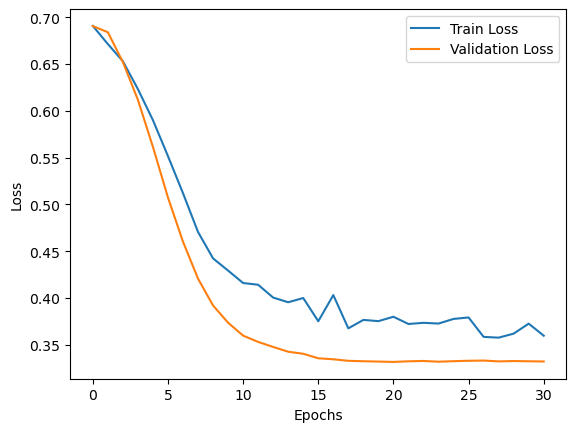

In [132]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


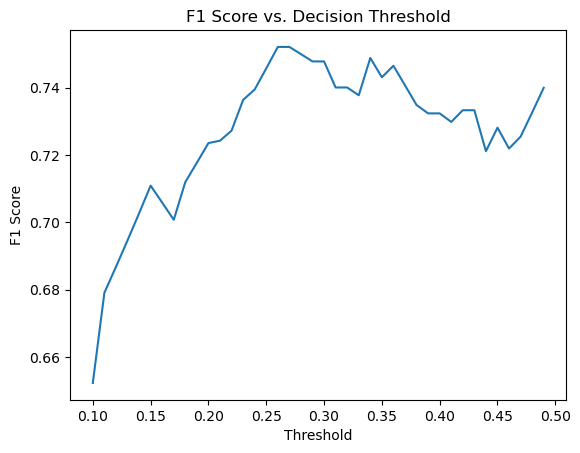

In [141]:
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_val, (model.predict(x_val) > t).astype("int32")) for t in thresholds]
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Decision Threshold')
plt.show()

np.float64(0.2799999999999999)

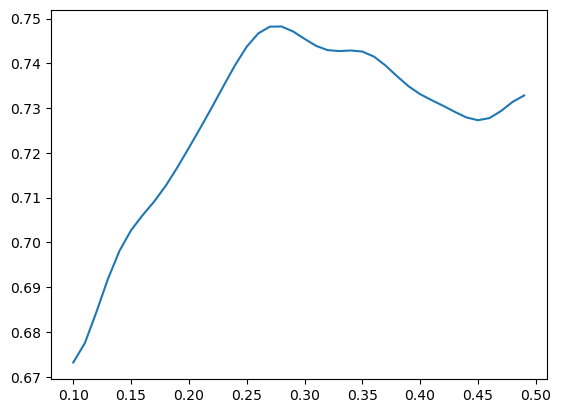

In [157]:
# Smooth f1_scores
from scipy.ndimage import gaussian_filter1d
smoothed_f1_scores = gaussian_filter1d(f1_scores, sigma=2)
plt.plot(thresholds, smoothed_f1_scores)
chosen_threshold = thresholds[smoothed_f1_scores.argmax()]
chosen_threshold

## Inferencia del modelo

In [162]:
x_test = test_df.drop(columns=['has_diabetes'], errors='ignore')
predictions = model.predict(x_test.drop(columns=['patient_id'], errors='ignore'))
x_test['has_diabetes'] = (predictions >= chosen_threshold).astype(int)
x_test['patient_id'] = test_df['patient_id'].astype(int)
# patient_00001 format
x_test['patient_id'] = 'patient_' + x_test['patient_id'].astype(str).str.zfill(5)
x_test[['patient_id', 'has_diabetes']].to_csv('predictions-simple-keras.csv', index=False)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
